# SYS 611: SimPy Queuing System

Paul T. Grogan <pgrogan@stevens.edu>

This example creates a queuing system simulation in SimPy.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `matplotlib.pyplot` and `simpy` libraries. SimPy is not a standard library included in most Python distributions. The `!pip install simpy` command below attempts to install it using the pip package management system.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the matplotlib pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

!pip install simpy

# import the simpy package
import simpy

## Simulation Model

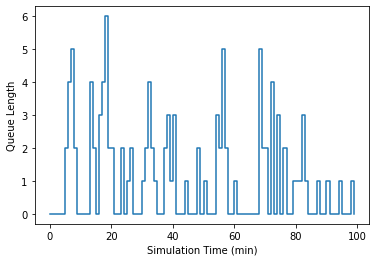

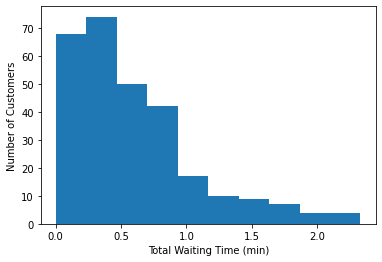

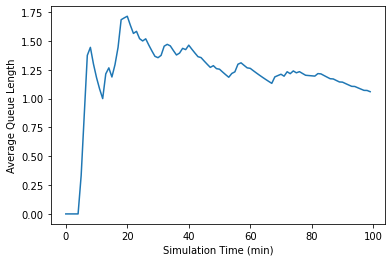

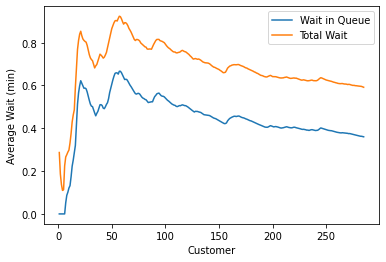

In [2]:
# create the simulation environment
env = simpy.Environment()

# create arrays to record data
wait_queue = []
wait_total = []
obs_time = []
obs_length_queue = []

# create the servers resource
servers = simpy.Resource(env, capacity=1)
        
def cafe_run(env, servers, _lambda, _mu):
    """ Process for simulating a cafe.

    Args:
        env (simpy.Environment): the simulation environment
        servers (simpy.Resource): the servers resource
        _lambda (float): the average inter-arrival rate (customers/minute)
        _mu (float): the average service rate (customers/minute)
    """
    while True:
        # wait for the next arrival
        yield env.timeout(np.random.exponential(1/_lambda))
        # launch the customer process
        env.process(handle_customer(env, servers, _mu))

def handle_customer(env, servers, _mu):
    """ Process for simulating a customer.

    Args:
        env (simpy.Environment): the simulation environment
        servers (simpy.Resource): the servers resource
        _mu (float): the average service rate (customer/minute)
    """
    with servers.request() as request:
        arrival_time = env.now
        # wait to get a server
        yield request
        service_time = env.now
        wait_queue.append(service_time - arrival_time)
        # wait for the service to complete
        yield env.timeout(np.random.exponential(1/_mu))
        depart_time = env.now
        wait_total.append(depart_time - arrival_time)

def observe(env, servers):
    """ Process to observe the queue length during a simulation.

    Args:
        env (simpy.Environment): the simulation environment
        servers (simpy.Resource): the servers resource
    """
    while True:
        # record the observation time and queue length
        obs_time.append(env.now)
        obs_length_queue.append(len(servers.queue))
        # wait for the next minute
        yield env.timeout(1.0)

# add the cafe process
env.process(cafe_run(env, servers, 3.0, 4.0))
# add the observation process
env.process(observe(env, servers))
# run the simulation for 100 minutes
env.run(until=100)

# create a plot showing the queue length at each time
plt.figure()
plt.step(obs_time, obs_length_queue, where='post')
plt.xlabel('Simulation Time (min)')
plt.ylabel('Queue Length')
plt.show()

# create a plot showing the histogram of waiting time
plt.figure()
plt.hist(wait_total)
plt.xlabel('Total Waiting Time (min)')
plt.ylabel('Number of Customers')
plt.show()

# create a plot showing the average queue length at each time
plt.figure()
plt.plot(obs_time, np.cumsum(obs_length_queue)/np.arange(1, 1+len(obs_length_queue)))
plt.xlabel('Simulation Time (min)')
plt.ylabel('Average Queue Length')
plt.show()

# create a plot showing the average wait time (queue and total) at each time
plt.figure()
plt.plot(1+np.arange(len(wait_queue)), np.cumsum(wait_queue)/np.arange(1, 1+len(wait_queue)), label='Wait in Queue')
plt.plot(1+np.arange(len(wait_total)), np.cumsum(wait_total)/np.arange(1, 1+len(wait_total)), label='Total Wait')
plt.xlabel('Customer')
plt.ylabel('Average Wait (min)')
plt.legend()
plt.show()

## Monte Carlo Simulation

In [3]:
NUM_RUNS = 10

# array to store outputs
AVERAGE_WAIT = []

for i in range(NUM_RUNS):
    # set the initial seed
    np.random.seed(i)

    # create the simulation environment
    env = simpy.Environment()

    # create arrays to record data
    wait_queue = []
    wait_total = []
    obs_time = []
    obs_length_queue = []

    # create the servers resource
    servers = simpy.Resource(env, capacity=1)
    # add the cafe process
    env.process(cafe_run(env, servers, 3.0, 4.0))
    # add the observation process
    env.process(observe(env, servers))
    # run the simulation
    env.run(until=100)
    
    # record the final average waiting time
    AVERAGE_WAIT.append(np.mean(wait_total))

# print final results to console
print('Average waiting time for N={:} runs:'.format(NUM_RUNS))
print('\n'.join('{:.2f}'.format(i) for i in AVERAGE_WAIT))

# write results to CSV file
import csv

with open('queuing.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['Run', 'Avg. Total Waiting Time'])
    for i, sample in enumerate(AVERAGE_WAIT):
        writer.writerow([i+1, sample])

Average waiting time for N=10 runs:
0.98
0.60
1.65
0.68
0.74
0.76
1.06
0.92
3.11
1.12
